In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random
using Plots
using VectorizedRoutines;

In [1]:
#Hyperparameters
n = 10
N = 300
σₐ = 0.001
bound = 1

k_range = 100
k_list = [i for i=1:100] #November 3
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
k_list_lite = [i for i in 1:k_range]
k_real = 20
k = k_real;

#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [94]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

#Create a Random Network
@model function generator(x::Array{Float64}, k=12)
    α = 0.009 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    print(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    #scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))
    
end;

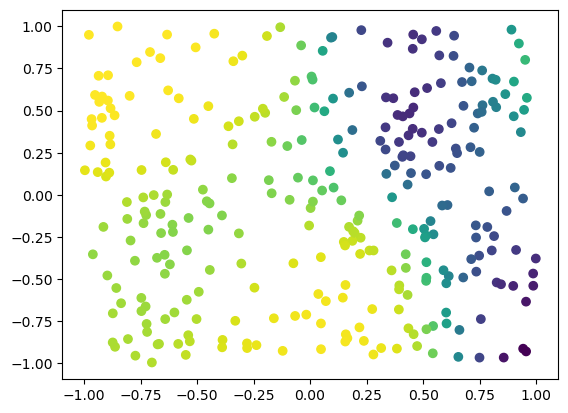

20

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5cf78f10>

In [102]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

#y_real = Flux.σ.(G(x.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
y_real = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
#y_real = y_fake
plot_data(x_raw,y_real)

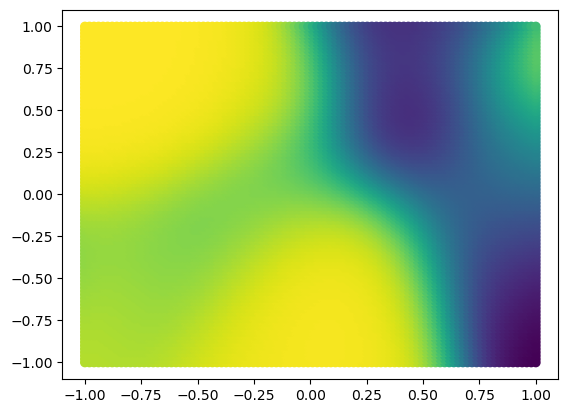

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5ef31890>

In [103]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k_real))[1,:]
plot_data(grid_raw, z)

In [113]:
#Classifier Network Tries to Learn the Generator Network

#@dist k_count() = categorical([1/length(k_list) for i=1:length(k_list)]) + 1

@gen function classifier(x::Array{Float64})
    α = 0.09 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.002 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [114]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

obs2 = choicemap()::ChoiceMap
obs2[:y] = y_real

#println(y_real)
#println(y_fake)

(trace1,) = generate(classifier, (x,), obs)
(trace2,) = generate(classifier, (x,), obs2)

score1 = exp(get_score(trace1)/length(y_real))
score2 = exp(get_score(trace2)/length(y_real))

println(score1)
println(score2)
println(score1/score2)

3.6829430215311766e-9
9.787118386537833e-61
3.7630514683433884e51


In [105]:
#Register Observed Data
x_samp, y_samp = sample_data(x, y_real)
x_samp = transpose(x_samp)
size(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

7.26547097304021

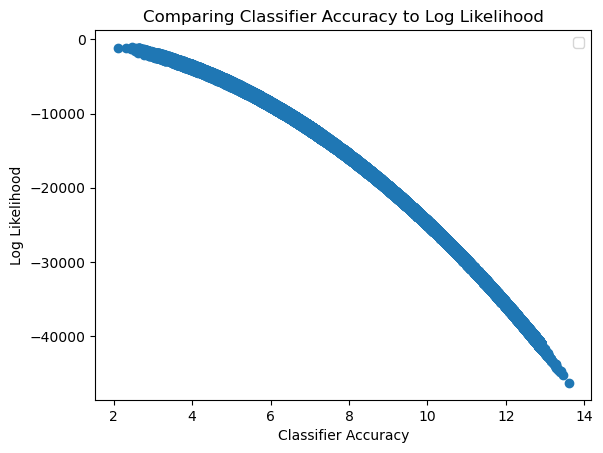

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f7a5d27d650>

In [118]:
#Plot of Log Likelihood Scores
x_samp, y_samp = sample_data(x, y_real)
#x_samp, y_samp = x, y_real
x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master;

scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    x_samp, y_samp = sample_data(x, y_real)
    #x_samp, y_samp = x, y_real
    x_samp = transpose(x_samp)
    obs_master = choicemap()::ChoiceMap
    obs_master[:y] = y_samp
    obs = obs_master;
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    #print(k)
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[:k]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:100000
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

#for j=1:20
    #new_distances1 = [ks[i] == j ? distances[i] : -1 for i=1:length(distances)]
    #new_distances = filter(x -> x != -1, new_distances1)
    #new_scores1 = [ks[i] == j ? scores[i] : 100 for i=1:length(scores)]
    #new_scores = filter(x -> x < 100, new_scores1)
    #scatter(new_distances,new_scores,label=j)
#end
#plt.xlim(0,200)
#plt.ylim(-6000,0)
PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()
#println(best_trace[:k])
#println(best_dist)
#println(best_ks)

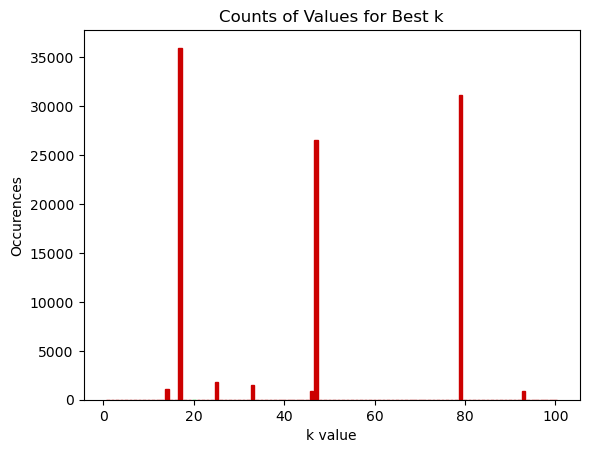

22
-9163.410884220304


In [119]:
#print(best_ks)
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([best_ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])
println(best_trace[:k])
println(get_score(best_trace))
plt.title("Counts of Values for Best k")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [120]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = vcat(Wₕ,[uniform(-10,10) for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[uniform(-10,10) for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[uniform(-10,10) for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [129]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        #current_k = obs[:k]
        #println("w: $current_k")
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=1, eps=0.05, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function across_dimension(trace, iters, obs)
    #selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    #args = get_args(trace)
    #argdiffs = map((_) -> NoChange(), args)
    #(new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:iters
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=1, eps=0.27, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("Old Trace Dist: $dist")
    
    Wₕ = new_trace[:Wₕ]
    Wₒ = new_trace[:Wₒ]
    bₕ = new_trace[:bₕ]
    bₒ = new_trace[:bₒ]
    k = new_trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("New Trace Dist: $dist")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    logscore = (score2 - score1)
    score = exp(logscore)
    println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        obs_master[:y] = y_samp
        obs = obs_master;
        if i%100 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #print(obs[:k])
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 20000
starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
x_samp, y_samp = x, y_real
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 12
0.0
0.0
0.0
0.0
Inf
0.0
3.306286370405204e-77
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Inf
0.013360254193443761
Inf
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Epoch 100 Within Acceptance Prob: 0.017857142857142856
Epoch 100 Across Acceptance Prob: 0.06976744186046512
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.157295327555956e-283
0.0
0.0
1.9946e-319
1.1847223861952248e-120
0.0
0.0
1.7008716268999285e-279
3.959068056155761e-118
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.315494624e-315
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.67860097684231e31
1.033207177765329e-32
1.033207177765329e-32
1.033207177765329e-32
1.033207177765329e-32
0.0
0.0
Epoch 200 Within Acceptance Prob: 0.009708737864077669
Epoch 200 Across Acceptance Prob: 0.041666666666666664
1.033207177765329e-32
1.033207177765329e-32
1.033207177765329e-32
1.033207177765329e-32
0.0
0.0
0.0
1.033207177765329e-32
0.0
Inf
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Epoch 2700 Within Acceptance Prob: 0.0007304601899196494
Epoch 2700 Across Acceptance Prob: 0.0037593984962406013
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Epoch 2800 Within Acceptance Prob: 0.000700770847932726
Epoch 2800 Across Acceptance Prob: 0.0036443148688046646
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Epoch 2900 Within Acceptance Prob: 0.0006756756756756757
Epoch 2900 Across Acceptance Prob: 0.0035236081747709656
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

InterruptException: InterruptException:

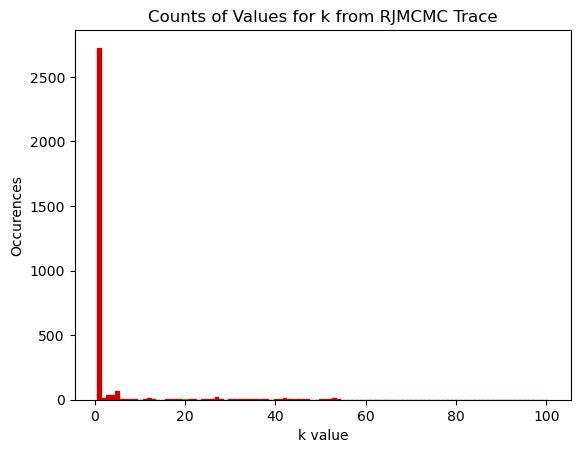

In [112]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

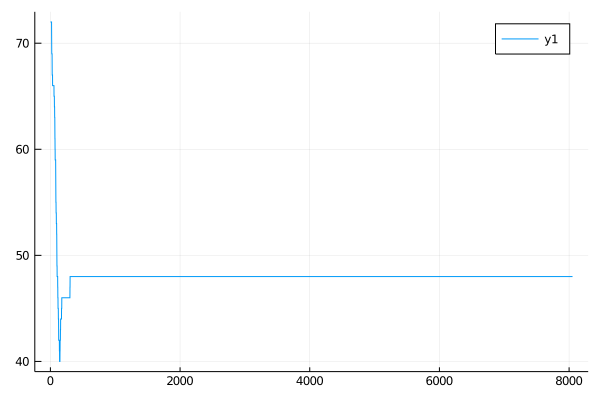

In [56]:
Plots.plot(ks)

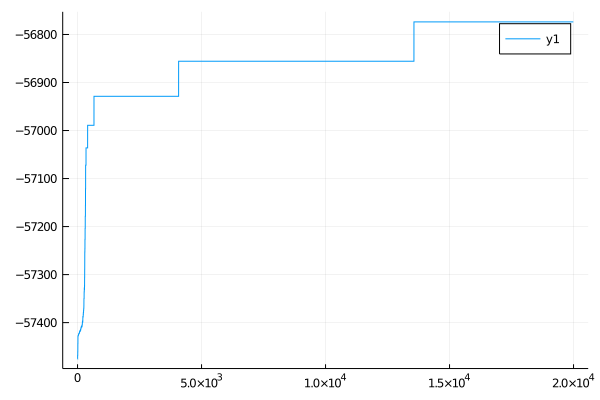

In [67]:
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores[10:length(scores)])
#print(length(scores))

In [102]:
#Try Dynamic Plotting

anim = @animate for i ∈ 1:runs
    colors = ["lightblue" for i=1:k_range]
    colors[k_real] = "lightgreen"
    colors[ks[i]] = "red"
    Plots.histogram(
        ks[1:i], 
        bins=1:k_range+1,
        fillcolor=colors),
        title="Estimated Marginal Posterior Distribution of k",
        xlabel="k: Number of Hidden Nodes",
        ylabel="Occurences",
        legend=false
    )
end

gif(anim, "anim_fps20000.gif", fps = 20000)

LoadError: syntax: unexpected ")"

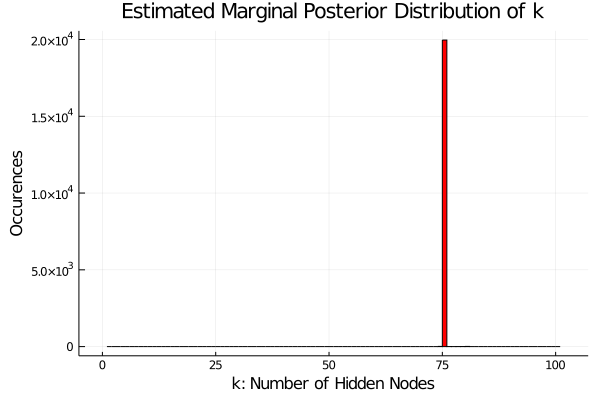

In [68]:
colors = ["lightblue" for i=1:k_range]
colors[k_real] = "lightgreen"
colors[ks[length(ks)]] = "red"
p4 = Plots.histogram(
    ks, 
    bins=1:k_range+1, 
    fillcolor=colors, 
    title="Estimated Marginal Posterior Distribution of k",
    xlabel="k: Number of Hidden Nodes",
    ylabel="Occurences",
    legend=false
)


In [81]:
#Fixed Network Time: Figure out which k is actually best

#Return a Flexible Network
function model(k::Int) 
    return Chain(
        Dense(2, k, σ),
        Dense(k, 1, σ))
end;

num_params(model) = sum(length, Flux.params(model)) 

round4(x) = round(x, digits=4)

penalty(m) = sum(abs2, Flux.params(m)[1]) + sum(abs2, Flux.params(m)[2]) + sum(abs2, Flux.params(m)[3])
loss(y_hat, y) = Flux.Losses.mse(y_hat, y) #+ penalty(m)

function getdata(x,y)
    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(x)

    # One-hot-encode the labels
    ytrain = Flux.flatten(y_real)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=N, shuffle=true)

    return train_data
end

y_hat = (model(6))(x)
test_model = model(6)
#println(Flux.params(test_model)[1])
#println(Flux.params(test_model)[2])
#println(Flux.params(test_model)[3])
#println(Flux.params(test_model)[4])
print(lossa(y_hat, y_real, model(6)))

function eval_loss_accuracy(x, y, net)
    return loss(net(x), y)
end

function train(x,y,m,epochs)
    losses = []
    
    # Load Data
    train_data = getdata(x,y)

    # Construct model
    loss(x,y) = Flux.Losses.mse(m(x), y) + penalty(m)
    
    ## Training
    opt = Flux.Optimise.ADAM()

    for i=1:epochs
        Flux.train!(loss, Flux.params(m), train_data, opt)
        loss1 = eval_loss_accuracy(x,y,m)
        push!(losses,loss1)
        #println(Flux.params(m))
    end
    return m, losses
end

UndefVarError: UndefVarError: lossa not defined

In [67]:
training_runs = 500
a,b,c,d,e = 10, 30, 50, 70, 90

m1 = model(a)
m1_trained, losses1 = train(x, y_real, m1, training_runs);

In [68]:
m2 = model(b)
m2_trained, losses2 = train(x, y_real, m2, training_runs);

In [69]:
m3 = model(c)
m3_trained, losses3 = train(x, y_real, m3, training_runs);

In [70]:
m4 = model(d)
m4_trained, losses4 = train(x, y_real, m4, training_runs);

In [71]:
m5 = model(e)
m5_trained, losses5 = train(x, y_real, m5, training_runs);

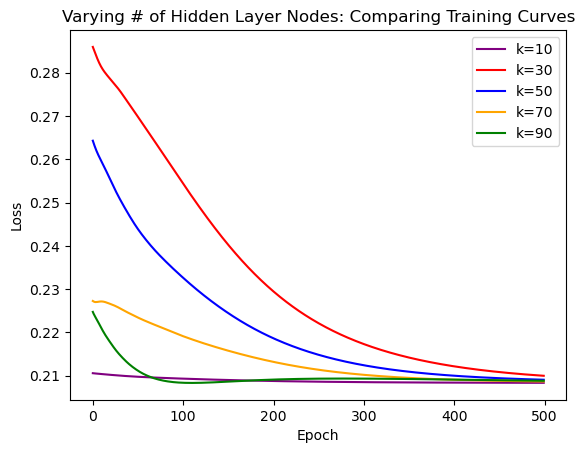

PyObject <matplotlib.legend.Legend object at 0x7fc2b103e490>

In [72]:
PyPlot.plot(losses1, color="purple", label="k=$a")
PyPlot.plot(losses2, color="red", label="k=$b")
PyPlot.plot(losses3, color="blue", label="k=$c")
PyPlot.plot(losses4, color="orange", label="k=$d")
PyPlot.plot(losses5, color="green", label="k=$e")
PyPlot.title("Varying # of Hidden Layer Nodes: Comparing Training Curves")
PyPlot.xlabel("Epoch")
PyPlot.ylabel("Loss")
PyPlot.legend()

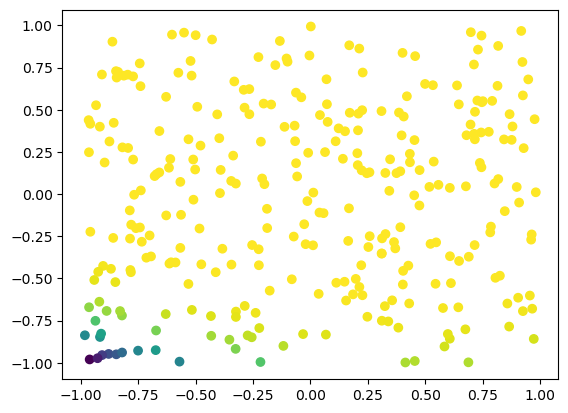

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5e78c990>

In [69]:
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        #print(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

Q = 100
y_prime = zeros(length(y_real))

for j=1:Q
    rand_i = rand((1:length(traces)))
    #print(rand_i)
    test_trace = traces[rand_i]
    tWₕ = test_trace[:Wₕ]
    tWₒ = test_trace[:Wₒ]
    tbₕ = test_trace[:bₕ]
    tbₒ = test_trace[:bₒ]
    tk = test_trace[:k]
    #println(tk)

    y_test = Flux.σ.(G(x,tWₕ,tbₕ,tWₒ,tbₒ,tk)[1,:])
    y_prime += y_test .* (1/Q)
    #println(euclidean(y_test, y_real))
end

plot_data(x_raw,y_prime)

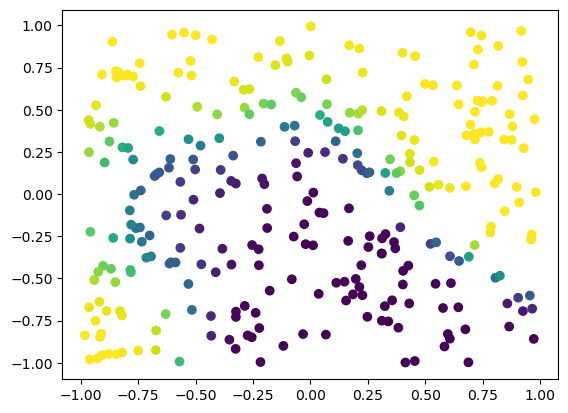

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5f3fd2d0>

In [70]:
plot_data(x_raw,y_real)

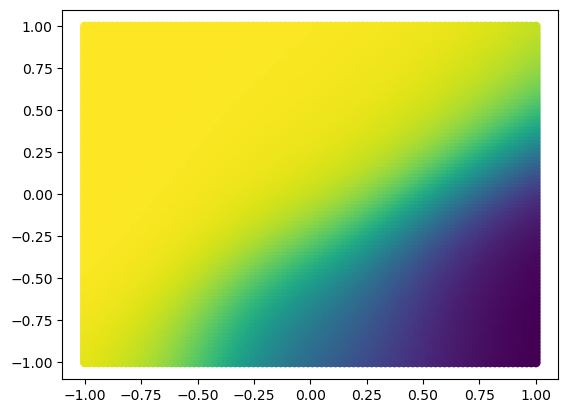

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5d9a5610>

In [121]:
function tracegrid(trace, low=-1.0, high=1.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    #Neural Net Parameters
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]

    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z = Flux.σ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k))[1,:]
    plot_data(grid_raw, z)
end

tracegrid(best_trace)

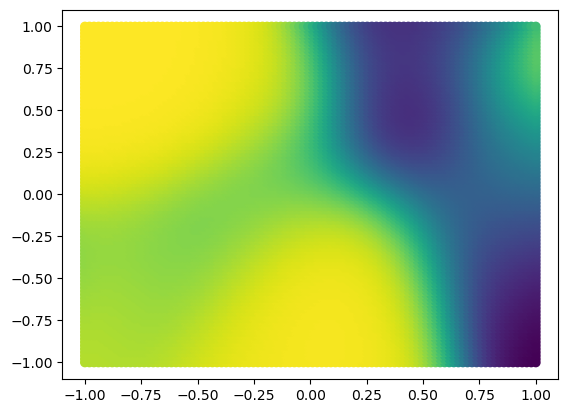

PyObject <matplotlib.collections.PathCollection object at 0x7f7a5d7dc150>

In [122]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k_real))[1,:]
plot_data(grid_raw, z)